Import required Python libraries

In [51]:
import scipy.io
import numpy as np
import operator as op

Import and configure matplotlib for plotting

In [52]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt # matplotlib
matplotlib.rcParams['figure.figsize'] = list(map(lambda x: 2*x, matplotlib.rcParams['figure.figsize']))
matplotlib.style.use('ggplot')

Define data container for MSI experiments

In [53]:
"""
Data container for MSI measurements
"""
class MSIData(object):
    def __init__(self, data_matrix, mz_values, row2grid, nonnull_spots):
        self._data = data_matrix
        self._mz_values = mz_values.flatten()
        self._mz_dict = {mz: index for index, mz in enumerate(mz_values.flatten())}
        self._row2grid = row2grid
        self._nonnull_spots = nonnull_spots
    
    @property
    def data(self):
        """"Returns the data matrix."""
        return self._data
    
    @property
    def mz_values(self):
        """"Returns the m/z values that were measured."""
        return self._mz_values
    
    @property
    def row2grid(self):
        """Returns a conversion table of data rows to x/y coordinates."""
        return self._row2grid
    
    @property
    def nonnull_spots(self):
        """Indicates which spots were measured."""
        return self._nonnull_spots
    
    @property
    def mz_dict(self):
        """Returns a dictionnary of m/z values to data row indices."""
        return self._mz_dict
    
    @property
    def y_size(self):
        return max(map(op.itemgetter(0), self.row2grid)) + 1
        
    @property
    def x_size(self):
        return max(map(op.itemgetter(1), self.row2grid)) + 1
    
    @property
    def ndatarows(self):
        """Returns the number of data rows."""
        return self.data.shape[0]
    
    @property
    def ndatacols(self):
        """Returns the number of data columns."""
        return self.data.shape[1]
    
    @property
    def nbins(self):
        return len(self.mz_values)
    
    def colToMatrix(self, col, indices=None):
        """
        Converts data column into matrix.
        
        If col is a subset of rows, indices indicates the corresponding row indices.
        """
        if (indices == None):
            assert (len(col) == self.ndatarows)
            indices = range(self.ndatarows)
        mat = np.zeros((self.y_size, self.x_size))
        for rowidx, val in zip(indices, col):
            row, col = self.row2grid[rowidx]
            mat[row, col] = val
        return mat
    
    def getIonImageByIndex(self, index):
        """Returns the ion image at specified index as a numpy matrix."""
        rows = self.data[:, index]
        return self.colToMatrix(rows)
    
    def getIonImageByMZ(self, mz_value):
        """Returns the ion image at specified m/z value as a numpy matrix.
        
        Throws a KeyError if specified m/z value is not included in this data.
        """
        index = self.mz_dict.get(mz_value, default=None)
        if index is None: 
            raise KeyError("%f not in mz_values" % mz_value)
        else:
            return getIonImageByIndex(index)
    
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, key):
        """Returns the mass spectrometry vector at given data index."""
        return self.data[key, :]
        
    def __str__(self):
        return "MSI data set:\n- x_size: \t %d\n- y_size: \t %d\n- nbins: \t %d" % (self.x_size, self.y_size, self.nbins)
    
    def transpose(self):
        """Returns a new MSI data set that is the transpose of this."""
        transposed_row2grid = np.zeros(self.row2grid.shape, dtype=np.uint32)
        transposed_row2grid[:,0] = self.row2grid[:, 1]
        transposed_row2grid[:,1] = self.row2grid[:, 0]
        return MSIData(data_matrix = self.data,
                       mz_values = self.mz_values,
                       row2grid = transposed_row2grid, 
                       nonnull_spots = self.nonnull_spots)
        

# Load data set

In [54]:
data = scipy.io.loadmat('coronal_lipid_neg_pp.mat')
data.keys()

dict_keys(['peak_blc_iec_aligned_mzs', 'original_rows', '__header__', 'y_size', 'nonnull_spots', 'feat_size', '__version__', 'row2grid', 'grid2row', 'mz_values', 'ans', 'blc_iec_ms_rows_aligned_pp', 'x_size', '__globals__'])

Some statistics about the raw data before encapsulating it in the MSIData container.

In [55]:
rows = data["y_size"][0][0]
cols = data["x_size"][0][0]
bins = data["feat_size"][0][0]
print("rows: %d, cols: %d, m/z bins %d" % (rows, cols, bins))

mz_values = data["mz_values"]
feat_size = data["feat_size"]
row2grid = data["row2grid"]
grid2row = data["grid2row"]
nonnull_spots = data["nonnull_spots"]

data_matrix = data["blc_iec_ms_rows_aligned_pp"]

rows: 77, cols: 127, m/z bins 26624


In [56]:
msi_data = MSIData(data_matrix = data_matrix, 
                   mz_values = mz_values, 
                   row2grid = row2grid.astype(np.int32) - 1,  # matlab indexing is 1-based, python is 0-based
                   nonnull_spots = nonnull_spots)
print(msi_data)

MSI data set:
- x_size: 	 77
- y_size: 	 127
- nbins: 	 26624


Lambda function to plot an ion image based on an MSIData object and mass bin index.

In [57]:
plotIonImg = lambda data, index: plt.imshow(data.getIonImageByIndex(index))

In [58]:
msi_data_transp = msi_data.transpose()
print(msi_data_transp)

MSI data set:
- x_size: 	 127
- y_size: 	 77
- nbins: 	 26624


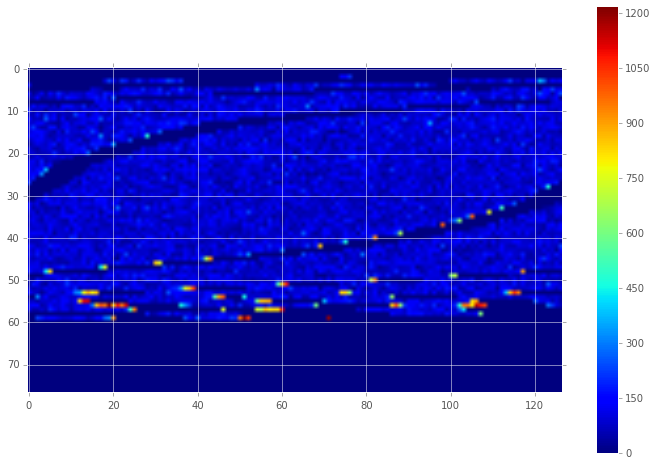

In [59]:
plotIonImg(msi_data_transp, 325)

plt.colorbar()
plt.show()

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import preprocessing

see data

In [61]:
X = data_matrix
print(X)
X.shape

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


(7625, 792)

After pre_processing and peak picking, use support vector machine
labling: pick a m/z value. create labels by defining a threshold for one specific m/z bin (molecule) e.g.choose m/z = 325

# Labelling

(array([  1.57500000e+03,   7.60000000e+01,   2.17000000e+02,
          3.51000000e+02,   5.97000000e+02,   7.22000000e+02,
          7.89000000e+02,   7.26000000e+02,   6.58000000e+02,
          4.95000000e+02,   3.96000000e+02,   2.66000000e+02,
          2.26000000e+02,   1.60000000e+02,   8.80000000e+01,
          6.30000000e+01,   4.00000000e+01,   2.10000000e+01,
          1.60000000e+01,   1.10000000e+01,   8.00000000e+00,
          7.00000000e+00,   3.00000000e+00,   5.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   3.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

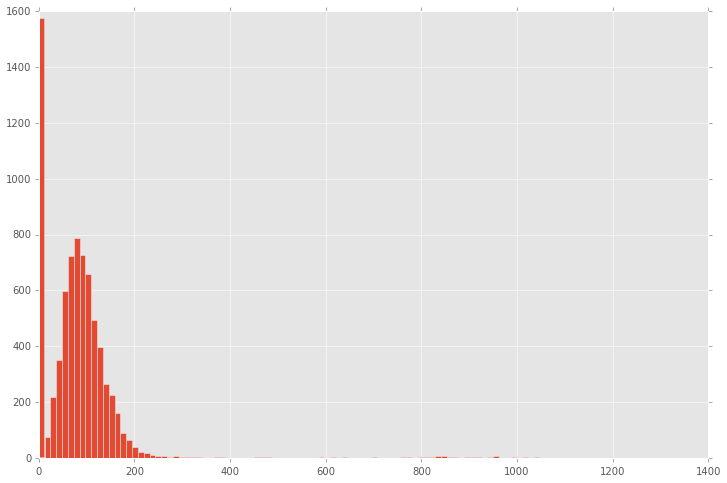

In [62]:
label_bin = 325
Y=X[:, label_bin]
plt.hist(Y, bins=100)

In [63]:
threshold = 5
binarizer = preprocessing.Binarizer(threshold=threshold)
X_L=binarizer.transform(Y)
y1=X_L.T
y1.shape
npos = np.sum(y1)
print("%d positives, %d negatives" % (npos, y1.shape[0]-npos))

6062 positives, 1563 negatives


/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


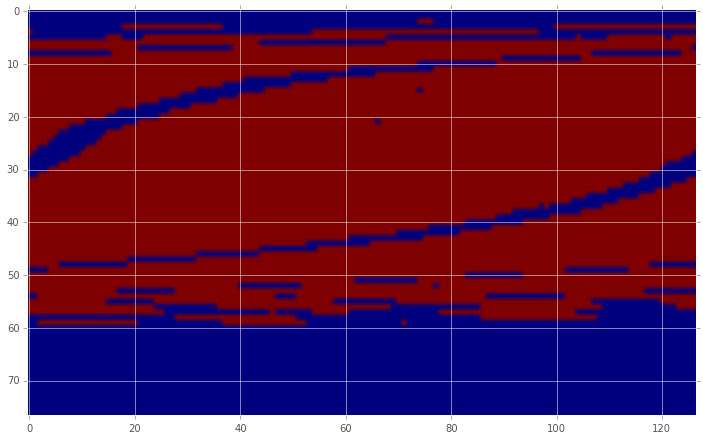

In [64]:
labelplot = msi_data_transp.getIonImageByIndex(label_bin) > threshold
plt.imshow(labelplot)

In [65]:
c,r=y1.shape
y=y1.reshape(c,)
y.shape

(7625,)

In [66]:
X_new = X[:, np.arange(X.shape[1]) != label_bin]

# SVM

In [67]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics

In [68]:
clf = SVC(C=1, kernel='linear')

In [69]:
scores = cross_val_score(clf, X_new,y,cv=3,scoring='roc_auc')
scores.mean()

0.99910120614764752